In [1]:
import time
import gensim
import jieba
import jieba.analyse
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt

## 1.训练word2vec模型

#### 打开语料库文件准备word2vec训练

In [2]:
with open('corpus_weibo.txt', 'rb') as fin:
    corpus_list = fin.read().decode('utf-8').splitlines()

#### 利用结巴分词对语料库进行分词

In [3]:
time1 = time.time()
lines = [jieba.lcut(corpus) for corpus in corpus_list]
print('分词时间 %f s' % (time.time() - time1))

Building prefix dict from the default dictionary ...
Loading model cost 1.031 seconds.
Prefix dict has been built succesfully.


分词时间 46.420145 s


#### 查看一个分词结果

In [4]:
'/'.join(lines[-1])

'【/国务院参事/牛文元/：/中国/去年/日均/500/起/群体/事件/】/牛文元/：/去年/，/广东/发生/了/乌坎/事件/。/实际上/，/2011/年/，/中国/平均/每天/发生/500/起/群体性/事件/，/这/意味着/，/现今/社会/容易/失序/，/民众/心理/容易/失调/，/效率/和/公平/需要/不断/协调/和/重建/。'

#### 训练word2vec模型

In [5]:
time1 = time.time()
m = gensim.models.Word2Vec(lines)
print('word2vec模型训练时间 %f s' % (time.time() - time1))

word2vec模型训练时间 22.905403 s


## 2.分析与中国有关的微博语料，获取关键词（主题词）及其词向量

#### 打开与中国有关的微博语料文件

In [6]:
with open('target_weibo.txt', 'rb') as fin:
    target_text = fin.read().decode('utf-8')

#### 利用TF-IDF构建语料关键词（主题词）
`allowPOS`参数对词性进行了限制，以下是比较常用的几个：
* ns 地名
* n 名词
* vn 名动词
* v 动词

更多与词性有关的资料，请查看http://blog.csdn.net/kevin_darkelf/article/details/39520881

In [7]:
time1 = time.time()
kw_list = jieba.analyse.extract_tags(target_text, topK=500, withWeight=True, allowPOS=['n', 'v', 'nr', 'ns', 'vn', 'a', 'l'])
print('提取关键词时间 %f s' % (time.time() - time1))

提取关键词时间 15.838495 s


#### 查看权重最大的10个关键词，关键词总数为500个，由`topK`参数确定

In [8]:
kw_list[:10]

[('中国', 0.1427278899238232),
 ('城管', 0.02797041429367398),
 ('吴英', 0.0253184069754981),
 ('国家', 0.02144154788818793),
 ('经济', 0.02136949955277585),
 ('社会', 0.021283590764639558),
 ('没有', 0.019067521308772786),
 ('美国', 0.019028127349534234),
 ('政府', 0.01764197201552124),
 ('问题', 0.017627668987355457)]

#### 将列表转化为`pandas series`

In [9]:
kw_weight = pd.Series({k:v for k,v in kw_list}, name='weight')
kw_weight.head()

上学    0.004514
上海    0.003211
不会    0.004528
不公    0.002287
不到    0.002347
Name: weight, dtype: float64

In [10]:
kw_weight.describe()

count    500.000000
mean       0.004534
std        0.006908
min        0.002175
25%        0.002620
50%        0.003292
75%        0.004676
max        0.142728
Name: weight, dtype: float64

#### 依据训练的word2vec模型，将关键词转化为100维的词向量。可能少数关键词word2vec模型没有训练到，需要剔除。

In [11]:
kw_vector = pd.DataFrame({k:m.wv[k] for k,v in kw_list if k in m.wv}).transpose()
kw_vector.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
上学,-1.223538,0.444382,-0.719591,-0.408937,-0.510438,-0.990453,1.034614,0.328811,-1.248890,-0.293374,...,-0.334563,0.041735,-0.408751,0.697230,-1.128547,-0.123847,0.566242,1.274025,0.838499,-0.058706
上海,-0.863662,-0.101245,-0.182039,-0.977415,0.327586,-0.152813,0.261375,0.062477,0.023476,-0.220330,...,1.292007,0.164160,0.166137,-0.498801,-0.142620,-0.304623,-0.441420,-1.181882,-0.162674,-0.412464
不会,1.888615,2.958393,-0.386099,1.402996,-0.854758,0.709788,1.108583,3.660176,-0.945219,0.053954,...,-1.914573,-0.851867,-0.496311,1.655657,1.378335,1.421097,1.441729,-1.947957,0.764114,0.683932
不公,-0.468147,-0.601798,-0.830426,0.934186,0.039733,-0.557142,0.336943,-0.007771,-0.483994,0.441932,...,0.272706,0.502967,-0.123750,0.291287,-0.436967,0.462093,0.721959,0.349388,0.297868,0.184687
不到,0.734668,1.502699,0.484009,-1.162092,-0.744608,2.116059,0.445526,0.527920,-0.626088,-0.955975,...,-1.338310,-0.259798,0.371065,0.350106,-0.995277,0.603689,1.139956,1.407035,0.698893,1.079052


#### 词向量当前没有归一化，一般采用余弦相似度表示两个词向量之间的相似度。

In [12]:
kw_vector.transpose().describe()

,上学,上海,不会,不公,不到,不卖,不同,不求人,不畏,不能,...,韩寒,韩方,项目,领域,领导,食品,食品安全,香港,马其顿,高铁
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.010627,0.071756,0.196715,0.039043,0.170454,0.010188,0.202949,0.114864,0.098742,0.194869,...,-0.003536,0.022924,0.050721,0.105042,0.061047,0.000173,0.030259,0.130843,0.004314,0.104961
std,0.900113,0.973036,1.487086,0.604221,1.061610,0.100003,1.062357,0.717098,0.724251,1.452841,...,0.626293,0.294215,0.964842,1.028495,1.485897,1.245185,0.448446,1.363941,0.504362,0.742701
min,-2.333584,-2.122440,-4.482497,-1.234656,-2.186650,-0.262916,-2.950614,-1.608649,-1.661491,-3.385009,...,-1.244408,-0.632853,-2.531135,-2.337152,-4.194022,-2.594336,-1.245149,-2.691990,-1.437438,-1.427345
25%,-0.569202,-0.569184,-0.927591,-0.381879,-0.590101,-0.056942,-0.477628,-0.392109,-0.458067,-0.949463,...,-0.440640,-0.185691,-0.505108,-0.601721,-1.121191,-0.890015,-0.235929,-0.864246,-0.319640,-0.477248
50%,0.064915,0.010357,0.142800,0.071756,0.132238,0.005995,0.304961,0.156031,0.089183,0.186395,...,-0.163815,0.020808,0.142721,0.107133,0.017004,-0.038208,0.063792,0.086960,-0.012152,0.078794
75%,0.632933,0.660272,1.355698,0.464364,0.782868,0.068212,0.830342,0.635535,0.524289,1.335770,...,0.371828,0.213484,0.702106,0.694584,1.274912,0.923960,0.359024,1.173326,0.281704,0.672539
max,2.100535,2.448521,3.660176,1.610498,2.834591,0.248826,2.905597,1.852468,2.791874,3.401500,...,1.575532,0.828176,2.069246,2.464769,2.943747,3.510368,1.061665,2.847558,1.206731,2.171439


#### 之后进行降维时距离度量不支持余弦相似度，这里对词向量进行归一化，之后用欧氏距离表示词向量之间的相似度。

In [13]:
n_kw_vector = kw_vector.div(kw_vector.std(axis=1), axis=0)
n_kw_vector.transpose().describe()

,上学,上海,不会,不公,不到,不卖,不同,不求人,不畏,不能,...,韩寒,韩方,项目,领域,领导,食品,食品安全,香港,马其顿,高铁
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.011806,0.073744,0.132282,0.064618,0.160562,0.101881,0.191036,0.160179,0.136337,0.134130,...,-0.005646,0.077917,0.052569,0.102131,0.041084,0.000139,0.067476,0.095930,0.008553,0.141323
std,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,-2.592545,-2.181255,-3.014281,-2.043384,-2.059750,-2.629072,-2.777423,-2.243276,-2.294081,-2.329924,...,-1.986942,-2.150992,-2.623368,-2.272400,-2.822553,-2.083495,-2.776589,-1.973686,-2.850013,-1.921831
25%,-0.632367,-0.584957,-0.623764,-0.632019,-0.555855,-0.569400,-0.449592,-0.546800,-0.632470,-0.653522,...,-0.703568,-0.631141,-0.523514,-0.585050,-0.754555,-0.714765,-0.526104,-0.633639,-0.633750,-0.642585
50%,0.072119,0.010644,0.096026,0.118758,0.124563,0.059952,0.287061,0.217586,0.123138,0.128297,...,-0.261563,0.070725,0.147922,0.104164,0.011444,-0.030685,0.142252,0.063756,-0.024093,0.106092
75%,0.703171,0.678568,0.911647,0.768533,0.737435,0.682098,0.781604,0.886260,0.723905,0.919419,...,0.593696,0.725606,0.727690,0.675340,0.858009,0.742027,0.800596,0.860247,0.558536,0.905531
max,2.333635,2.516372,2.461307,2.665412,2.670088,2.488178,2.735049,2.583284,3.854843,2.341275,...,2.515646,2.814872,2.144648,2.396482,1.981125,2.819155,2.367434,2.087744,2.392590,2.923706


#### 有时训练的word2vec模型没有我们提取的关键词，从权重`Series`中剔除这部分关键词

In [14]:
filtered_kw_weight = kw_weight[n_kw_vector.index]
len(filtered_kw_weight)

499

#### 利用AgglomerativeClustering对关键词进行层次聚类

In [15]:
ac = AgglomerativeClustering(30)
ac.fit(kw_vector)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=30,
            pooling_func=<function mean at 0x00000282D41A01E0>)

#### 利用聚类结果，给关键词打上标签，标签相同的是一类

In [16]:
kw_label = pd.Series(ac.labels_, index=kw_vector.index, name='label')
kw_label.head()

上学     6
上海     8
不会     7
不公    18
不到     7
Name: label, dtype: int64

#### 展示不同类的关键词

In [17]:
for group in kw_label.groupby(kw_label.values):
    print(list(group[1].index))

['不同', '产业', '体系', '健康', '全面', '公平', '农民', '创新', '原因', '合作', '因素', '土地', '垄断', '基本', '基础', '存在', '实现', '巨大', '带来', '建立', '影响', '很大', '投资', '推动', '模式', '民间', '消费', '消费者', '环境', '生态', '科技', '秩序', '程度', '稳定', '维稳', '能力', '融资', '行业', '计算', '资源', '透明', '道路', '重要', '金融', '限制', '面临', '领域']
['危机', '发展', '市场', '房价', '改革', '政策', '经济', '调控', '限购']
['事件', '事故', '发生', '校车', '案件', '死亡', '调查']
['东西', '人们', '关键', '出来', '反思', '变成', '和谐', '喜欢', '地方', '失去', '宽容', '幸福', '心理', '思考', '感觉', '才能', '改变', '时候', '机会', '比如', '现实', '生命', '生活', '百姓', '相信', '看到', '知道', '老百姓', '能够', '觉得', '贪官', '起来', '选择', '面对']
['了解', '代表', '作为', '关注', '决定', '包括', '参与', '告诉', '呼吁', '希望', '建议', '强调', '意见', '成立', '批评', '承认', '指出', '接受', '提出', '支持', '来自', '组织', '继续', '获得', '表示', '要求', '观点', '认为', '讨论', '评价', '质疑']
['先生', '发表', '同志', '教授', '文章', '新闻', '方舟子', '电影', '电脑', '电视', '评论', '贺卫方', '领导']
['上学', '专业', '个人', '全部', '公务员', '农村', '医生', '城市', '大学', '学习', '学校', '学生', '家庭', '成功', '教育', '梦想', '游客', '老师', '部分']
['不会', '不到', '不能', '只能', '可能

## 3.利用t-SNE对词向量降维可视化，制作词云

#### 使用t-SNE将词向量映射到2维

In [18]:
tsne = TSNE()
time1 = time.time()
kw_tsne_v = tsne.fit_transform(n_kw_vector)
print('t-SNE降维时间: %f s' % (time.time() - time1))

t-SNE降维时间: 12.400964 s


#### 将`Array`格式二维词向量转化为`DataFrame`

In [19]:
kw_tsne_df = pd.DataFrame(kw_tsne_v, index=n_kw_vector.index, columns=['x', 'y'])
kw_tsne_df.head()

,x,y
上学,-18.973070,-2.812257
上海,-14.265671,-22.216150
不会,-12.746803,20.069956
不公,5.031781,15.533661
不到,0.646695,26.849852


In [20]:
kw_tsne_df.describe()

,x,y
count,499.000000,499.000000
mean,1.052312,-0.538023
std,11.406988,13.595643
min,-21.442959,-28.413694
25%,-7.735441,-12.431802
50%,0.713971,0.781664
75%,9.674068,9.948457
max,27.430445,26.849852


#### 大致观察降维结果

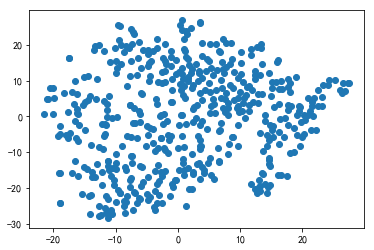

In [21]:
plt.scatter(kw_tsne_df['x'], kw_tsne_df['y']); plt.show()

#### 将关键词的标签、降维后的xy坐标、权重汇总到一个`DataFrame`中

In [22]:
kw_df = pd.concat([kw_label, kw_tsne_df, filtered_kw_weight], axis=1)
kw_df.head()

,label,x,y,weight
上学,6,-18.973070,-2.812257,0.004514
上海,8,-14.265671,-22.216150,0.003211
不会,7,-12.746803,20.069956,0.004528
不公,18,5.031781,15.533661,0.002287
不到,7,0.646695,26.849852,0.002347


In [23]:
kw_df.describe()

,label,x,y,weight
count,499.000000,499.000000,499.000000,499.000000
mean,11.525050,1.052312,-0.538023,0.004539
std,8.510381,11.406988,13.595643,0.006914
min,0.000000,-21.442959,-28.413694,0.002175
25%,4.000000,-7.735441,-12.431802,0.002623
50%,9.000000,0.713971,0.781664,0.003293
75%,18.000000,9.674068,9.948457,0.004678
max,29.000000,27.430445,26.849852,0.142728


#### 利用`matplotlib`绘制词云。相对位置为词之关键词间的关联度，颜色为关键词类，大小为关键词权重（的1/2次方）。
如果matplotlib出现中文乱码问题，参考https://www.zhihu.com/question/25404709

In [24]:
plt.figure(figsize=(18,18))
axis = plt.subplot(111)
plt.axis('off')
axis.scatter(kw_df['x'], kw_df['y'], s=np.sqrt(kw_df['weight']) * 3000, alpha=0.6, c=kw_df['label'], cmap='jet')
axis.set_title('与“中国”有关的微博中出现的关键词')
for index, row in kw_df.iterrows():
    axis.annotate('%d%s' % (row['label'], index), (row['x'], row['y']), alpha=0.8)

#### 保存词云图片

In [25]:
plt.savefig('kw_cloud.png', dpi=200)

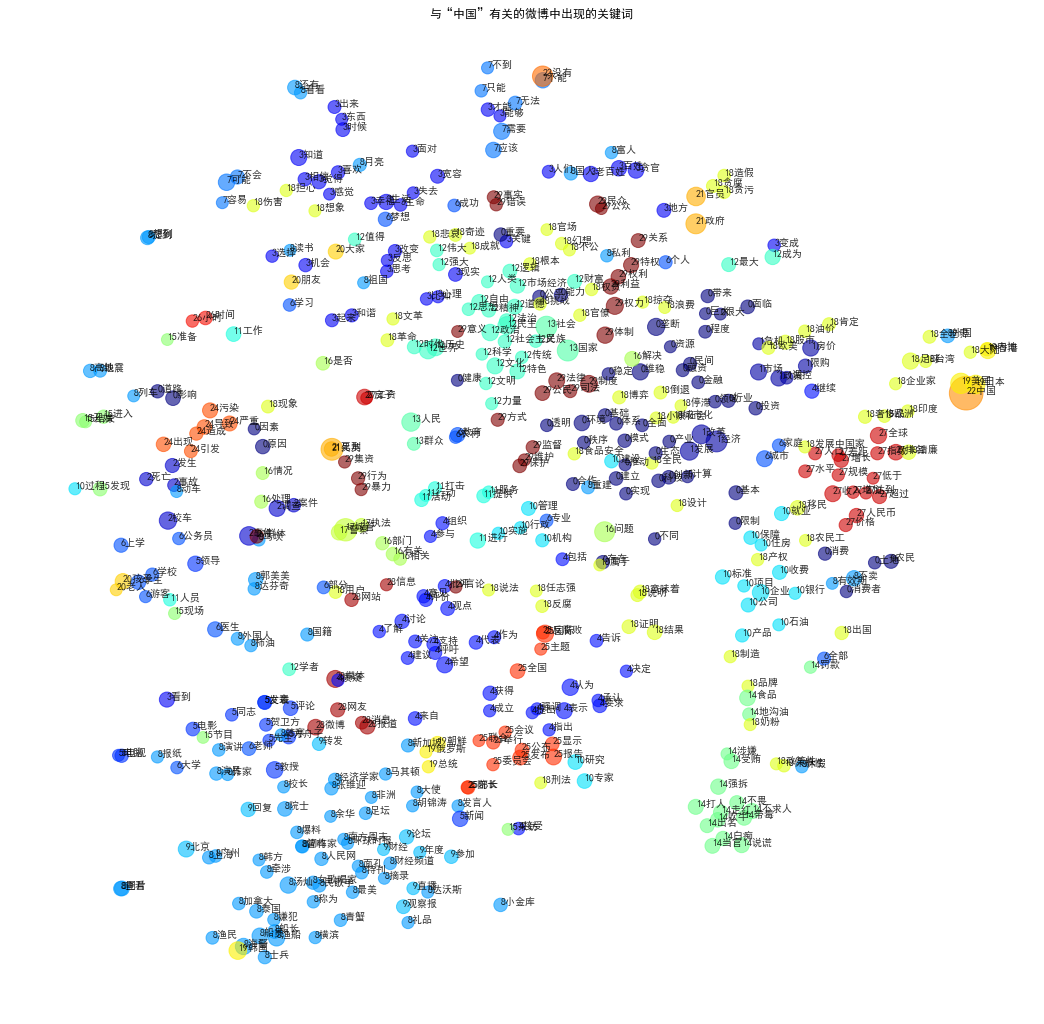

In [26]:
plt.show()